In [1]:
import importlib
import utilities3
importlib.reload(utilities3)
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer

In [2]:
ntrain = 1000
ntest = 100

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

r = 5
h = int(((421 - 1)/r) + 1)
s = h

modes = 12
width = 32

In [3]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, 2))

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.rfft(x, 2, normalized=True, onesided=True)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.in_channels,  x.size(-2), x.size(-1)//2 + 1, 2, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.irfft(out_ft, 2, normalized=True, onesided=True, signal_sizes=( x.size(-2), x.size(-1)))
        return x

class SimpleBlock2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(SimpleBlock2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(3, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm2d(self.width)
        self.bn1 = torch.nn.BatchNorm2d(self.width)
        self.bn2 = torch.nn.BatchNorm2d(self.width)
        self.bn3 = torch.nn.BatchNorm2d(self.width)


        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y = x.shape[1], x.shape[2]

        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn0(x1 + x2)
        x = F.relu(x)
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn1(x1 + x2)
        x = F.relu(x)
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn2(x1 + x2)
        x = F.relu(x)
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y)
        x = self.bn3(x1 + x2)


        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Net2d(nn.Module):
    def __init__(self, modes, width):
        super(Net2d, self).__init__()

        """
        A wrapper function
        """

        self.conv1 = SimpleBlock2d(modes, modes,  width)


    def forward(self, x):
        x = self.conv1(x)
        return x.squeeze()


    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))

        return c

def compl_mul2d(a, b):
    # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
    op = partial(torch.einsum, "bixy,ioxy->boxy")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

In [4]:
dataloader = utilities3.MatReader('data/piececonst_r421_N1024_smooth1.mat')
x_train = dataloader.read_field('coeff')[:ntrain,::r,::r][:,:s,:s]
y_train = dataloader.read_field('sol')[:ntrain,::r,::r][:,:s,:s]

dataloader = utilities3.MatReader('data/piececonst_r421_N1024_smooth2.mat')
x_test = dataloader.read_field('coeff')[:ntest,::r,::r][:,:s,:s]
y_test = dataloader.read_field('sol')[:ntest,::r,::r][:,:s,:s]

In [5]:
print(f'The shape of x_train is {x_train.shape} and the shape of y_train is {y_train.shape}')
print(f'The shape of x_test is {x_test.shape} and the shape of y_test is {y_test.shape}')

The shape of x_train is torch.Size([1000, 85, 85]) and the shape of y_train is torch.Size([1000, 85, 85])
The shape of x_test is torch.Size([100, 85, 85]) and the shape of y_test is torch.Size([100, 85, 85])


In [6]:
x_normalizer = utilities3.UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = utilities3.UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)

In [7]:
print(f'The shape of x_train is {x_train.shape} and the shape of y_train is {y_train.shape}')
print(f'The shape of x_test is {x_test.shape} and the shape of y_test is {y_test.shape}')

The shape of x_train is torch.Size([1000, 85, 85]) and the shape of y_train is torch.Size([1000, 85, 85])
The shape of x_test is torch.Size([100, 85, 85]) and the shape of y_test is torch.Size([100, 85, 85])


In [8]:
grids = []
grids.append(np.linspace(0, 1, s))
grids.append(np.linspace(0, 1, s))
grid = np.vstack([xx.ravel() for xx in np.meshgrid(*grids)]).T
grid = grid.reshape(1,s,s,2)
grid = torch.tensor(grid, dtype=torch.float)

In [9]:
x_train = torch.cat([x_train.reshape(ntrain,s,s,1), grid.repeat(ntrain,1,1,1)], dim=3)
x_test = torch.cat([x_test.reshape(ntest,s,s,1), grid.repeat(ntest,1,1,1)], dim=3)

In [10]:
print(f'The shape of x_train is {x_train.shape} and the shape of y_train is {y_train.shape}')
print(f'The shape of x_test is {x_test.shape} and the shape of y_test is {y_test.shape}')

The shape of x_train is torch.Size([1000, 85, 85, 3]) and the shape of y_train is torch.Size([1000, 85, 85])
The shape of x_test is torch.Size([100, 85, 85, 3]) and the shape of y_test is torch.Size([100, 85, 85])


In [11]:
train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [12]:
model = Net2d(modes, width).cuda()

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [16]:
# myloss = utilities3.LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(100):
    model.train()
    t1 = default_timer()
    train_mse = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        
        out = model(x)
        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        loss = F.mse_loss(model(x).view(-1), y.view(-1), reduction='mean')
#         loss = myloss(out.view(batch_size,-1), y.view(batch_size,-1))
        loss.backward()


        optimizer.step()
        train_mse += loss.item()


    model.eval()
    abs_err = 0.0
    rel_err = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            out = y_normalizer.decode(model(x))
            rel_err+= F.mse_loss(model(x).view(-1), y.view(-1), reduction='mean')
#             rel_err += myloss(out.view(batch_size,-1), y.view(batch_size,-1)).item()

    train_mse/= ntrain
    abs_err /= ntest
    rel_err /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, rel_err)

0 3.905803800000001 0.0001721178682637401 tensor(1.1164e-05, device='cuda:0')
1 3.4678374000000076 7.700964684772771e-06 tensor(3.8756e-06, device='cuda:0')
2 3.4712475999999697 3.842808891931781e-06 tensor(2.3626e-06, device='cuda:0')
3 3.5153096000000232 2.3877577368693894e-06 tensor(1.5831e-06, device='cuda:0')
4 3.5389768000000004 1.9066794666287023e-06 tensor(1.2598e-06, device='cuda:0')
5 3.785083900000018 1.3290163933561415e-06 tensor(9.1905e-07, device='cuda:0')
6 3.6632359999999835 1.408850317602628e-06 tensor(9.1944e-07, device='cuda:0')
7 3.718223899999998 1.29437157738721e-06 tensor(9.3619e-07, device='cuda:0')
8 3.496165700000006 1.14227463836869e-06 tensor(7.6391e-07, device='cuda:0')
9 3.4695955000000254 9.661658950790297e-07 tensor(9.4543e-07, device='cuda:0')
10 3.471863799999994 8.049990701692877e-07 tensor(4.5025e-07, device='cuda:0')
11 3.472690699999987 7.5688272863772e-07 tensor(5.9746e-07, device='cuda:0')
12 3.475187699999992 7.154382392400293e-07 tensor(4.8451e

In [17]:
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x)
        out = y_normalizer.decode(model(x))
        pred[index] = out

#         test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
#         print(index, test_l2)
        index = index + 1

In [18]:
print(f'The shape of predictions is {pred.shape} and the shape of ground truth is {y_test.shape}')

The shape of predictions is torch.Size([100, 85, 85]) and the shape of ground truth is torch.Size([100, 85, 85])


In [ ]:
plt.plot(pred[:,8191],'r-',label='Predictions')
plt.plot(y_test[:,8191],'b--',label='Ground Truth')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Actual vs Predicted')
plt.legend(loc='lower left')
plt.savefig('Output_burgers')
plt.show()

In [31]:
y_test[1,:,:][0]

tensor([1.6087e-06, 1.2269e-05, 1.9555e-05, 2.5308e-05, 3.0008e-05, 3.3872e-05,
        3.7016e-05, 3.9504e-05, 4.1373e-05, 4.2652e-05, 4.3411e-05, 4.3909e-05,
        4.5266e-05, 5.0119e-05, 4.3072e-05, 3.8536e-05, 3.7721e-05, 3.7843e-05,
        3.8339e-05, 3.9015e-05, 3.9777e-05, 4.0575e-05, 4.1381e-05, 4.2185e-05,
        4.2983e-05, 4.3780e-05, 4.4582e-05, 4.5400e-05, 4.6243e-05, 4.7122e-05,
        4.8051e-05, 4.9043e-05, 5.0119e-05, 5.1300e-05, 5.2615e-05, 5.4100e-05,
        5.5800e-05, 5.7756e-05, 5.9982e-05, 6.2376e-05, 6.4543e-05, 6.5995e-05,
        6.9049e-05, 8.1396e-05, 9.0850e-05, 9.5755e-05, 9.7859e-05, 9.8579e-05,
        9.8793e-05, 9.8969e-05, 9.9219e-05, 9.9425e-05, 9.9382e-05, 9.8905e-05,
        9.7909e-05, 9.6446e-05, 9.4669e-05, 9.2754e-05, 9.0836e-05, 8.8987e-05,
        8.7224e-05, 8.5530e-05, 8.3871e-05, 8.2208e-05, 8.0504e-05, 7.8724e-05,
        7.6841e-05, 7.4830e-05, 7.2672e-05, 7.0350e-05, 6.7849e-05, 6.5162e-05,
        6.2282e-05, 5.9211e-05, 5.5957e-

In [32]:
pred[1,:,:][0]

tensor([1.1075e-06, 8.7406e-06, 1.4247e-05, 1.8911e-05, 2.2996e-05, 2.6572e-05,
        2.9933e-05, 3.2872e-05, 3.5725e-05, 3.8218e-05, 4.0377e-05, 4.2485e-05,
        4.4781e-05, 4.6690e-05, 4.8498e-05, 5.0141e-05, 5.1846e-05, 5.3217e-05,
        5.4570e-05, 5.5932e-05, 5.7059e-05, 5.8264e-05, 5.9455e-05, 6.0338e-05,
        6.0984e-05, 6.2080e-05, 6.2882e-05, 6.3295e-05, 6.4219e-05, 6.4831e-05,
        6.5494e-05, 6.5813e-05, 6.6551e-05, 6.6721e-05, 6.7088e-05, 6.7924e-05,
        6.8315e-05, 6.8534e-05, 6.8606e-05, 6.8980e-05, 6.9621e-05, 6.9188e-05,
        6.9341e-05, 6.8809e-05, 6.9015e-05, 6.9018e-05, 6.8498e-05, 6.8497e-05,
        6.8236e-05, 6.7579e-05, 6.7337e-05, 6.6990e-05, 6.6517e-05, 6.6202e-05,
        6.5634e-05, 6.4851e-05, 6.3790e-05, 6.3587e-05, 6.2359e-05, 6.1619e-05,
        6.0580e-05, 5.9985e-05, 5.8962e-05, 5.8229e-05, 5.6998e-05, 5.5662e-05,
        5.4376e-05, 5.2895e-05, 5.1581e-05, 5.0176e-05, 4.8357e-05, 4.6492e-05,
        4.4729e-05, 4.2586e-05, 4.0240e-

In [21]:
F.mse_loss(pred,y_test)

tensor(3.0357e-06)

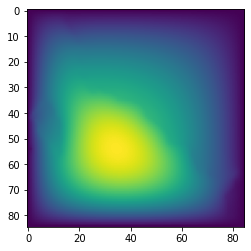

In [34]:
plt.imshow(y_test[99,:,:])

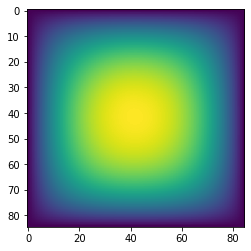

In [38]:
plt.imshow(pred[3,:,:])